In [209]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [210]:
epsilon = 1e-9

def solve_linear_system(A, f, epsilon=epsilon): # Методом Зейделя
    N = len(f)
    
    A = np.copy(A)
    f = np.copy(f)
    x_old = np.zeros(N)
    x_new = np.zeros(N)
    
    def norm(vec):
        return np.max(np.abs(vec))
    
    while norm(A @ x_old - f) >= epsilon:
        for i in range(N):
            x_new[i] = 0
            for j in range(i):
                x_new[i] += + A[i][j] * x_new[j]
            for j in range(i + 1, N):
                x_new[i] += A[i][j] * x_old[j]
            x_new[i] = (f[i] - x_new[i]) / A[i][i]
        x_old = x_new

    return x_new

def derivative(f, x, i, j, h=5e-5):
    x_1 = np.copy(x)
    x_1[j] += h
    x_2 = np.copy(x) 
    x_2[j] -= h
    return (f(x_1).ravel()[i] - f(x_2).ravel()[i]) / (2 * h)

def solve_newton(f, x, epsilon=epsilon):
    x = np.copy(x)
    original_shape = x.shape
    x = x.ravel()
    
    def f_flat(x):
        return f(x.ravel().reshape(original_shape)).ravel()
    
    N = len(f_flat(x))
    
    while np.sum(np.abs(f_flat(x.reshape(original_shape)))) > epsilon:
        J = np.array([[0.0] * N] * N)

        for i in range(N):
            for j in range(N):
                J[i][j] = derivative(f_flat, x, i, j)

        x = x + solve_linear_system(J, -f_flat(x))
    
    return x.reshape(original_shape)

################################################

class ButcherTable:
    def __init__(self, A):
        self.a = []
        self.c = []
        self.b = []
        
        self.s = len(A) - 1
        
        for i in range(self.s):
            self.a.append([])
            for j in range(self.s):
                self.a[i].append(A[i][j + 1])

            self.b.append(A[self.s][i + 1])
            
            self.c.append(A[i][0])

def solve_runge_kutta_explicit(tau, t, x, f, method, epsilon=epsilon):
    k = []
    for i in range(method.s):
        arg_1 = t + method.s * tau
        arg_2 = 0
        for j in range(i):
            arg_2 += method.a[i][j] * k[j]
        arg_2 *= tau
        arg_2 += x
        k.append(f(arg_1, arg_2))
    
    k = np.array(k)
    
    # print(f"explicit: {k}")
    
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
        
    return ret_val

def solve_runge_kutta_implicit(tau, t, x, f, method, epsilon=epsilon):
    def equation(k_0):
        k = []
        for i in range(method.s):
            arg_1 = t + method.s * tau
            arg_2 = 0
            for j in range(i):
                arg_2 += method.a[i][j] * k_0[j]
            arg_2 *= tau
            arg_2 += x
            k.append(f(arg_1, arg_2))
        
        k = np.array(k)
        return k - k_0
        
    k = solve_newton(equation, np.array([f(t, x) for _ in range(method.s)]), epsilon=epsilon)
    
    # print(f"implicit: {k}")
    
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
    
    return ret_val

################################################

def solve_adams(tau, t, x, f, N):
    if N > len(x):
        return solve_adams(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return x[n] + tau * (3 * f(t, x[n]) - 1 * f(t, x[n - 1])) / 2
            case 3:
                return x[n] + tau * (23 * f(t, x[n]) - 16 * f(t, x[n - 1]) + 5 * f(t, x[n - 2])) / 12
            case 4:
                return x[n] + tau * (55 * f(t, x[n]) - 59 * f(t, x[n - 1]) + 37 * f(t, x[n - 2]) - 9 * f(t, x[n - 3])) / 24

################################################

def solve_backward_differentiation_explicit(tau, t, x, f, N):
    if N > len(x):
        return solve_backward_differentiation_explicit(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return 2 / 3 * (tau * f(t, x[n]) - 1 / 2 * x[n - 1] + 2 * x[n])
            case 3:
                return 6 / 11 * (tau * f(t, x[n]) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n])
            case 4:
                return 12 / 25 * (tau * f(t, x[n]) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n])

def solve_backward_differentiation_implicit(tau, t, x, f, N, epsilon=epsilon):
    if N > len(x):
        return solve_backward_differentiation_implicit(tau, t, x, f, len(x), epsilon=epsilon)
    else:
        n = len(x) - 1
        match N:
            case 1:
                return solve_newton(lambda a: x[n] + tau * f(t, a) - a, x[n], epsilon=epsilon)
            case 2:
                return solve_newton(lambda a: 2 / 3 * (tau * f(t, a) - 1 / 2 * x[n - 1] + 2 * x[n]) - a, x[n], epsilon=epsilon)
            case 3:
                return solve_newton(lambda a: 6 / 11 * (tau * f(t, a) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n]) - a, x[n], epsilon=epsilon)
            case 4:
                return solve_newton(lambda a: 12 / 25 * (tau * f(t, a) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n]) - a, x[n], epsilon=epsilon)


In [211]:
class Solution:
    def __init__(self, t, x, x_dot):
        self.t = t
        self.x = x
        self.x_dot = x_dot


def plot_solutions(solution_containers, multidimensionals_solution=False):
    plt.figure(figsize=(12, 5))
    for solution_container in solution_containers:
        if multidimensionals_solution:
            for i in range(len(solution_container.solution.x[0])):
                plt.plot(solution_container.solution.t, [a[i] for a in solution_container.solution.x], label=f"{solution_container.name} (order: {solution_container.order}) ({i})") 
        else:
            plt.plot(solution_container.solution.t, solution_container.solution.x, label=f"{solution_container.name} (order: {solution_container.order})") 
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.title("Интегральные кривые")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.show()
    
    if not multidimensionals_solution:
        plt.figure(figsize=(12, 5))
        for solution_container in solution_containers:
            plt.plot(solution_container.solution.x, solution_container.solution.x_dot, label=f"{solution_container.name} (order: {solution_container.order})")    
        plt.xlabel("$x$")
        plt.ylabel("$\\dot(x)$")
        plt.title("Фазовые траектории")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
        plt.show()


# Лабораторная работа 1 Системы ОДУ

$$ y'' + e (y^2 - 1)y'+ y = 0, e > 0, y(0) = 2, y'(0) = 0 $$
$$
    \begin{cases}
        x'= z \\
        z' = e(1-x^2) z - x \\
        x(0) = 2 \\
        z(0) = 0
    \end{cases}
$$

In [212]:
def f(t, x):
    return np.array([
        x[1],
        np.exp(1) * (1 - x[0] ** 2) * x[1] - x[0],
    ])

## Методы Рунге-Кутта
[Источник](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)

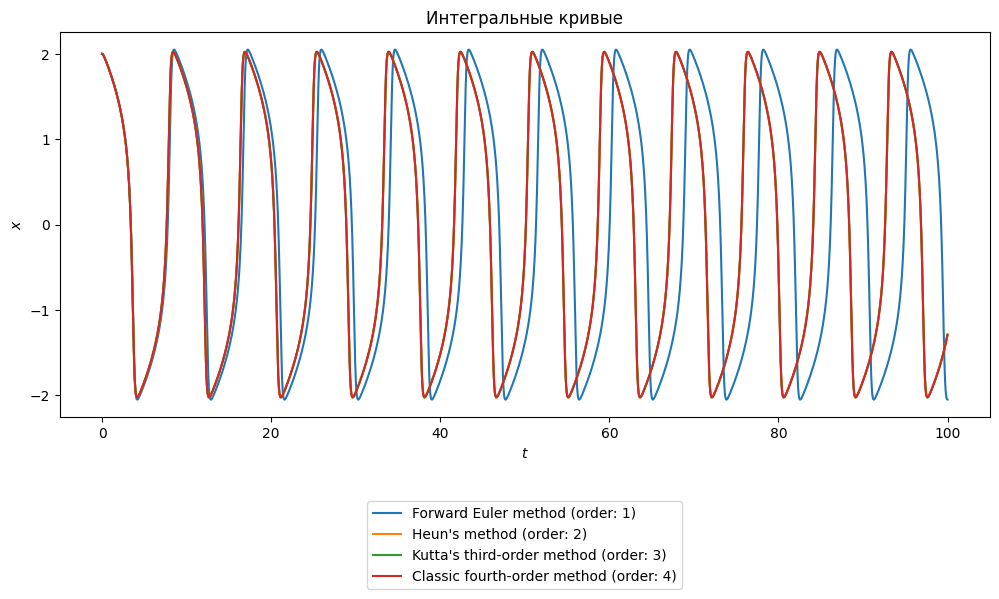

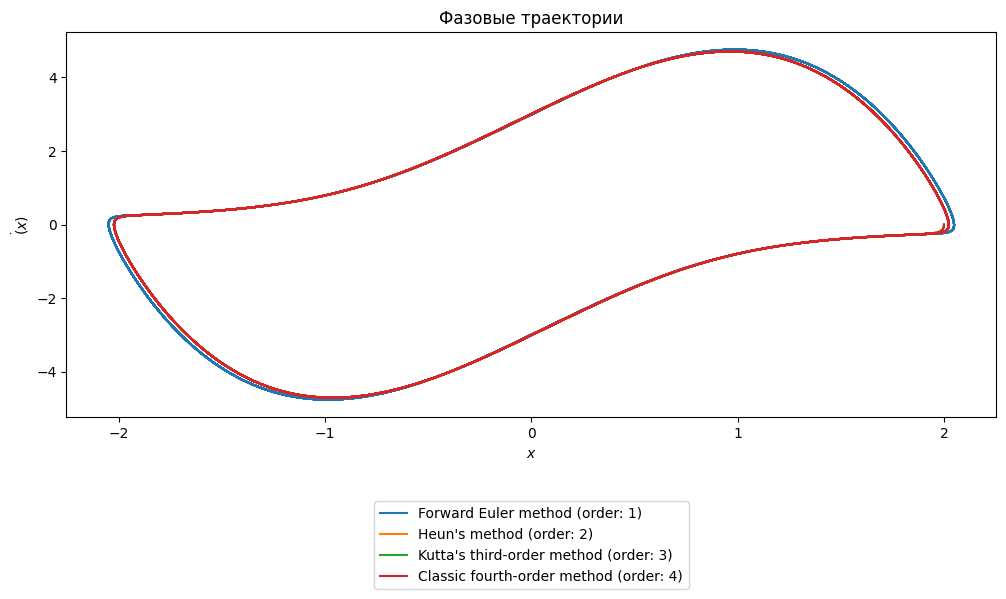

In [213]:
tau = 0.01
t_stop = 100

class RungeKuttaMethod:
    def __init__(self, name: str, order: int, table: ButcherTable):
        self.name = name
        self.order = order
        self.table = table
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Forward Euler method",
        1,
        ButcherTable(
            [
                [0.0, 0.0],
                [0.0, 1.0],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Heun's method",
        2,
        ButcherTable(
            [
                [0.0, 0.0, 0.0],
                [1.0, 1.0, 0.0],
                [0.0, 1/2, 1/2],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Kutta's third-order method",
        3,
        ButcherTable(
            [
                [0.0,  0.0, 0.0, 0.0],
                [1/2,  1/2, 0.0, 0.0],
                [1.0, -1.0, 2.0, 0.0],
                [0.0,  1/6, 2/3, 1/6],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Classic fourth-order method",
        4,
        ButcherTable(
            [
                [0.0, 0.0, 0.0, 0.0, 0.0],
                [1/2, 1/2, 0.0, 0.0, 0.0],
                [1/2, 0.0, 1/2, 0.0, 0.0],
                [1.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1/6, 1/3, 1/3, 1/6],
            ]
        )
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_runge_kutta_explicit(tau, t[i - 1], x[i - 1], f, method.table))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Методы Адамса

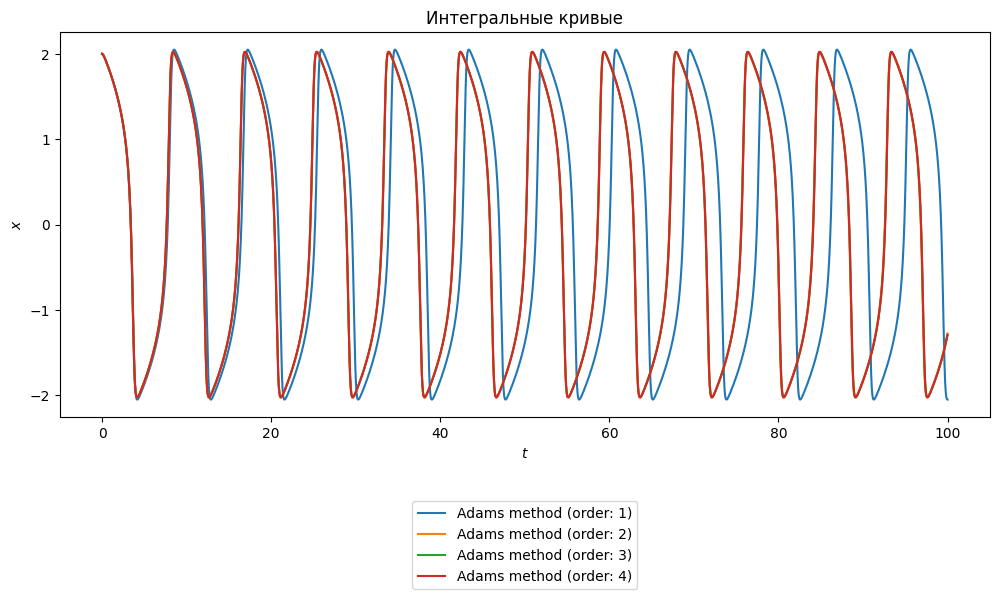

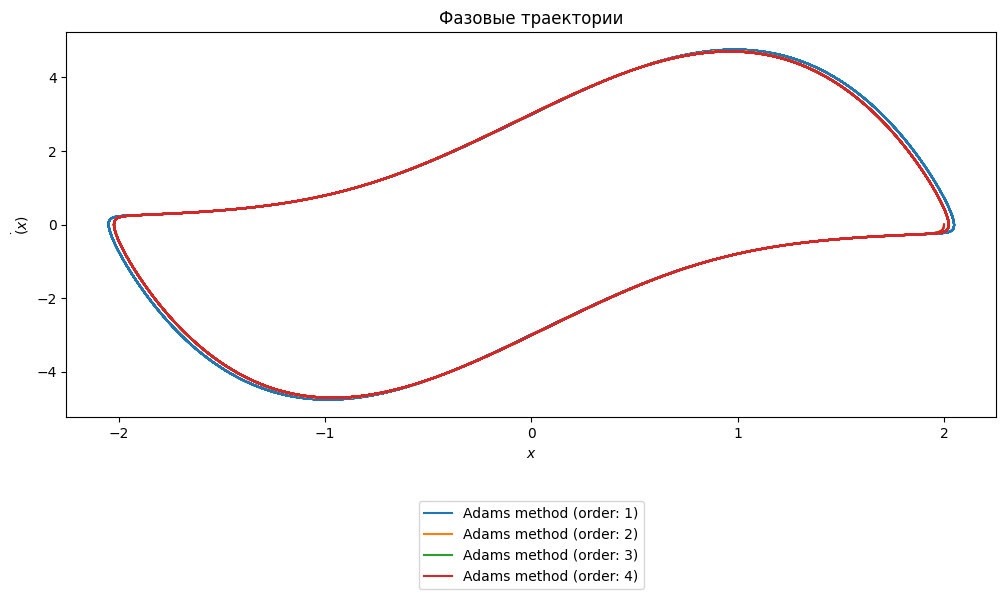

In [214]:
tau = 0.01
t_stop = 100

class AdamsMethod:
    def __init__(self, order: int):
        self.name = "Adams method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[AdamsMethod] = []

methods.append(
    AdamsMethod(
        1,
    )
)

methods.append(
    AdamsMethod(
        2,
    )
)

methods.append(
    AdamsMethod(
        3,
    )
)

methods.append(
    AdamsMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_adams(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Явные методы дифференцирования назад

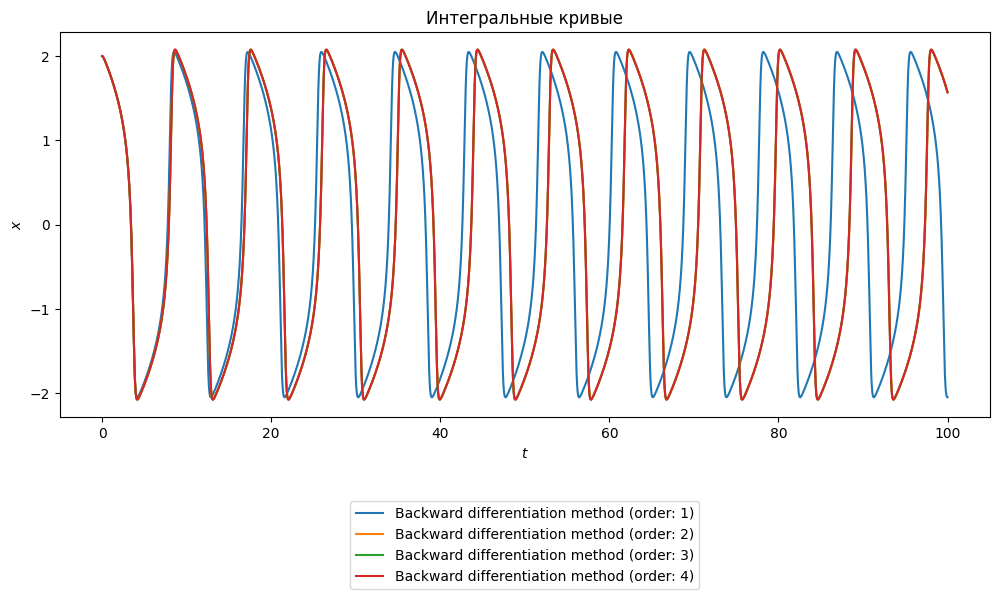

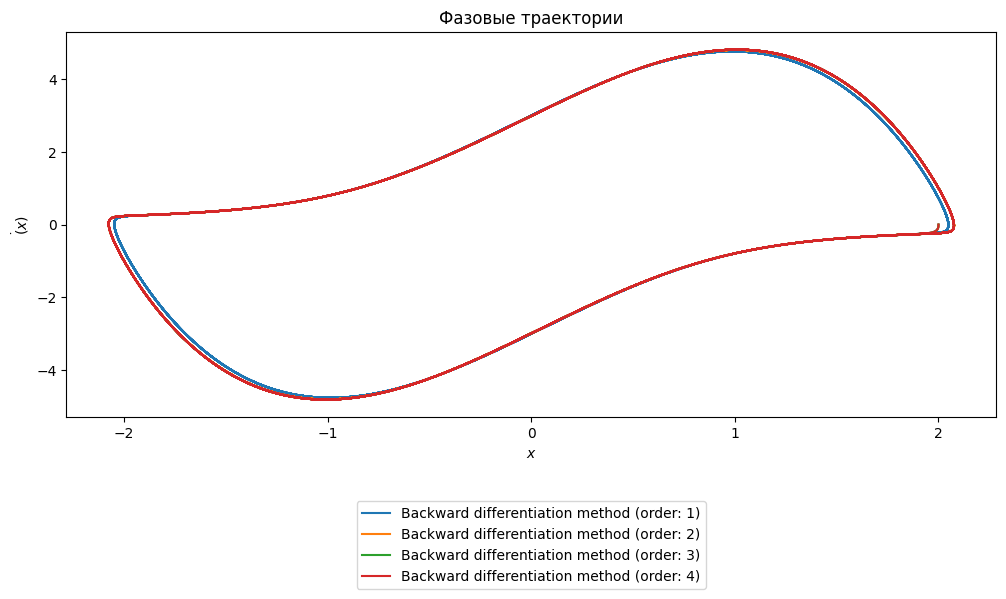

In [215]:
tau = 0.01
t_stop = 100
class BackwardDiffenetiationMethod:
    def __init__(self, order: int):
        self.name = "Backward differentiation method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[BackwardDiffenetiationMethod] = []

methods.append(
    BackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_backward_differentiation_explicit(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


# Лабораторная работа 2 Системы ОДУ (жёсткий вариант)

$$
\begin{cases}
    \dot{y}_1 = 77.27 (y_2 + y_1 (1 - 8.375 \cdot 10^{-6} y_1 - y_2)) \\
    \dot{y}_2 = \frac{1}{77.27} (y_3 - (1 + y_1) y_2) \\
    \dot{y}_3 = 0.161 (y_1 - y_2)
\end{cases}
$$

In [216]:
def f(_, x):
    return np.array([
        77.27 * (x[1] + x[0] * (1 - 8.375e-6 * x[0] - x[1])),
        1 / 77.27 * (x[2] - (1 + x[0]) * x[1]),
        0.161 * (x[0] - x[1])
    ])

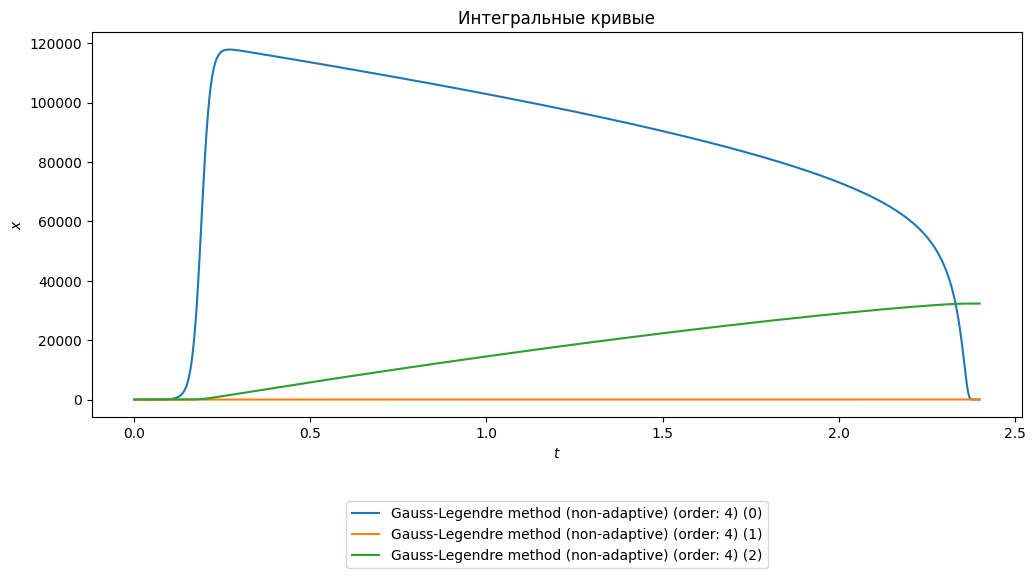

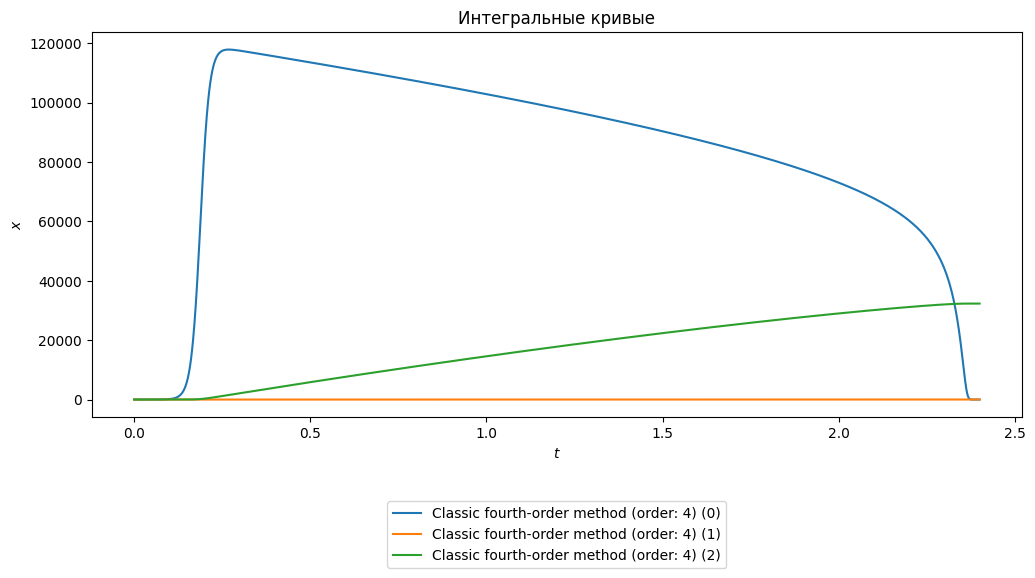

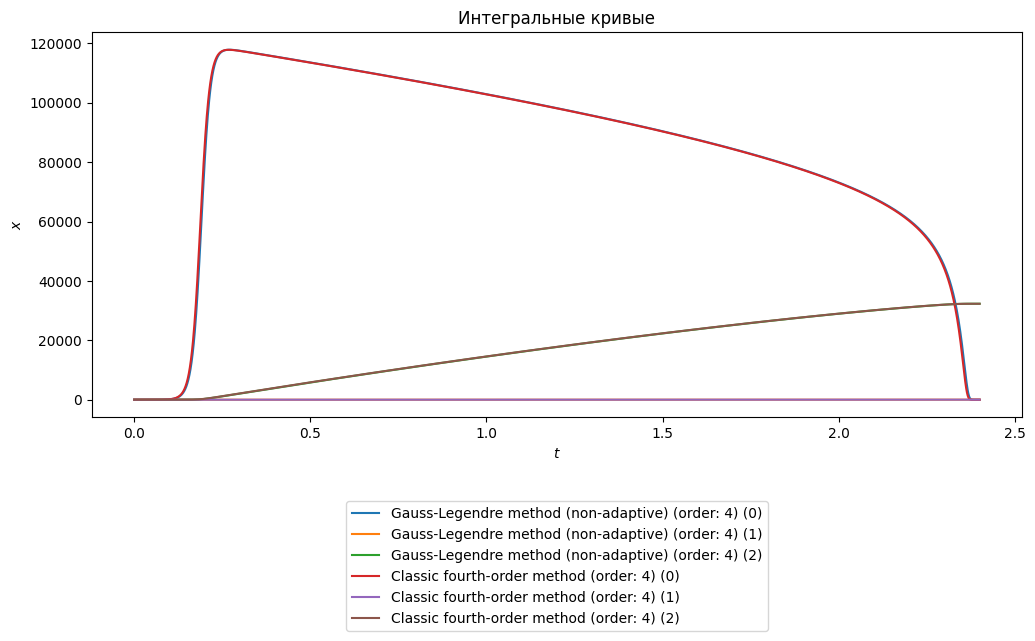

In [217]:
tau = 0.001
t_stop = 2.4

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Gauss-Legendre method (non-adaptive)",
        4,
        ButcherTable(
            [
                [1 / 2 - np.sqrt(3) / 6, 1 / 4                 , 1 / 4 - np.sqrt(3) / 6],
                [1 / 2 + np.sqrt(3) / 6, 1 / 4 + np.sqrt(3) / 6, 1 / 4                 ],
                [0                     , 1 / 2                 , 1 / 2                 ],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Classic fourth-order method",
        4,
        ButcherTable(
            [
                [0.0, 0.0, 0.0, 0.0, 0.0],
                [1/2, 1/2, 0.0, 0.0, 0.0],
                [1/2, 0.0, 1/2, 0.0, 0.0],
                [1.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1/6, 1/3, 1/3, 1/6],
            ]
        )
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([0.05, 0.05, 0.05])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_runge_kutta_implicit(tau, t[i - 1], x[i - 1], f, method.table, epsilon=1e-1))
        i += 1
    
    method.set_solution(
        t, 
        np.array(x),
        np.array(x),
    )
    
    plot_solutions([method], multidimensionals_solution=True)

plot_solutions(methods, multidimensionals_solution=True)


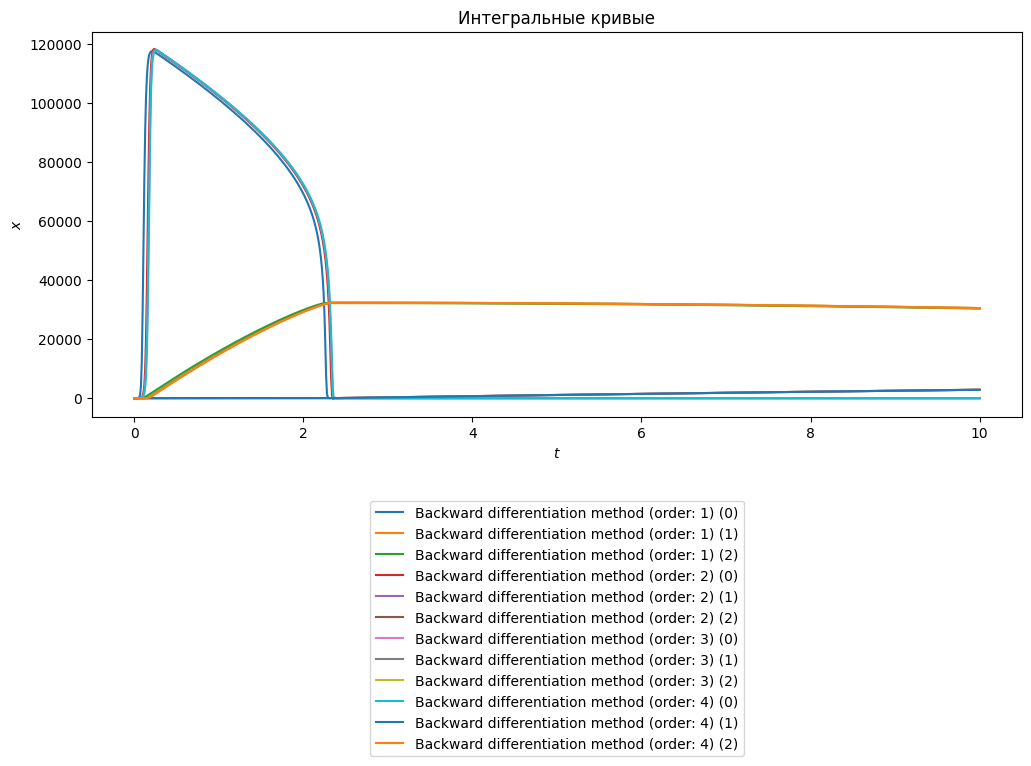

In [218]:
# tau = 0.01
tau = 0.01
t_stop = 10

methods: list[BackwardDiffenetiationMethod] = []

methods.append(
    BackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    BackwardDiffenetiationMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1

    x = [
        np.array([0.05, 0.05, 0.05])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_backward_differentiation_implicit(tau, t[i - 1], x, f, method.order, epsilon=1e-5))
        i += 1
    
    method.set_solution(
        t, 
        np.array(x),
        np.array(x),
    )
    
plot_solutions(methods, multidimensionals_solution=True)

# Лабораторная работа 3 Линейная КУ

$$y''-P^2(x)y=f(x)$$
$$P^2(x) = 10 + sin(2 \pi x)$$
$$f(x) = cos(2 \pi x)$$